# Renaissance Prediction Model

Create a model that predicts, based on pased and recent headlines, whether the statement belongs or not to recent times.

In [4]:
# first we import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import 

%matplotlib inline

In [2]:
# Checking out the dataset
df = pd.read_excel("Gisell.xlsx")
df.head()

,Renaissance,Text
0,0,"El TLC no sirvió, a México lo incrustaron, ni ..."
1,0,"Hay más de 80 millones de pobres, se exportan ..."
2,0,"Cedimos la banca nacional, no puedes competir ..."
3,0,"No está fluyendo el dinero, se dice que tienen..."
4,0,Las cajas de ahorro (casi 500) las había cread...


> **The 'Text' column contains the headlines for the training and testing set. The 'Renaissance' column is the binary dependent variable**

In [48]:
# Lets create some functions
def create_corpus(df, target):
    corpus = []
    for i in df[df["Renaissance"] == target].Text.str.split():
        for j in i:
            corpus.append(j)
    return corpus

# Removing punctuation
def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

# Removing the stopwores
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

def lematizer(text):
    text = [wordnet.lemmatize(word) for word in text.split()]
    return " ".join(text)

In [5]:
# Getting the spanish stop words
stop = set(stopwords.words("spanish"))

# Word Cloud
Given the fact that we have a binary classification task we can visualize the most common words that represent both categories, i.e '0' and '1'. But for that we have to clean the dataset and remove some words that represent no meaning when the model is trained.

In [6]:
# Make a copy of the original dataset so we can make some changes
df_2 = df.copy()

In [8]:
df_2.head()

,Renaissance,Text
0,0,"El TLC no sirvió, a México lo incrustaron, ni ..."
1,0,"Hay más de 80 millones de pobres, se exportan ..."
2,0,"Cedimos la banca nacional, no puedes competir ..."
3,0,"No está fluyendo el dinero, se dice que tienen..."
4,0,Las cajas de ahorro (casi 500) las había cread...


In [16]:
df_2["Text"] = df_2["Text"].map(remove_punct)

In [18]:
df_2["Text"] = df_2["Text"].map(lambda x: x.lower())

In [21]:
df_2["Text"] = df_2["Text"].map(remove_stopwords)

> **Creating the corpus for each category. The corpus represents the words in each one of the statements or headlines that lead to a negative ('0') valuation**

In [23]:
corpus0 = create_corpus(df_2, 0)
corpus1 = create_corpus(df_2, 1)

In [25]:
len(corpus0), len(corpus1)

(3415, 1806)

In [31]:
corpus0[0:15]

['tlc',
 'sirvió',
 'méxico',
 'incrustaron',
 'siquiera',
 'consultaron',
 '80',
 'millones',
 'pobres',
 'exportan',
 '30',
 'millones',
 'mexicanos',
 'trabajo',
 'cedimos']

In [32]:
corpus1[0:15]

['momento',
 'sumamente',
 'militar',
 'trump',
 'política',
 'proteccionista',
 'facto',
 'dice',
 'modelo',
 'neoliberal',
 'muerto',
 'existe',
 'globalización',
 'digital',
 'sustituyendo']

In [33]:
contador0 = Counter(corpus0)
contador1 = Counter(corpus1)

In [36]:
# the numnber of unique words
len(contador0), len(contador1)

(1855, 1182)

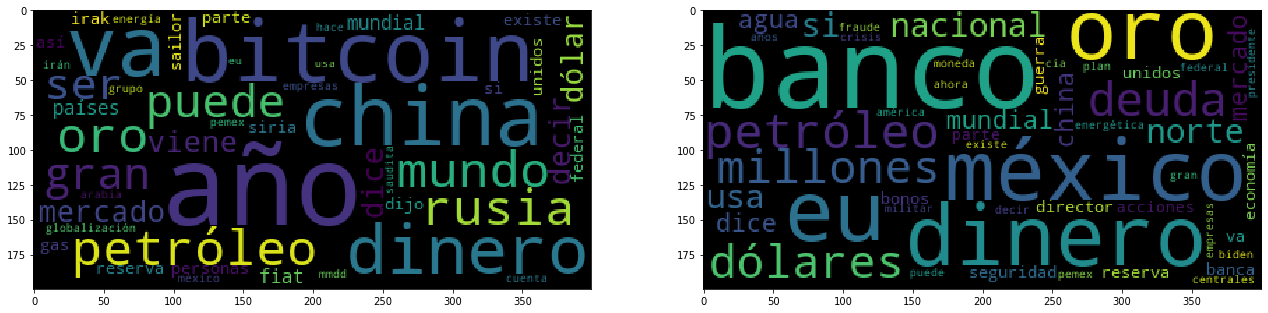

In [39]:
# now creating the word clouds
word_cloud0 = WordCloud(background_color='black', max_font_size=80).generate(
    " ".join([i[0] for i in contador0.most_common()[:50]])
)
word_cloud1 = WordCloud(background_color='black', max_font_size=80).generate(
    " ".join([i[0] for i in contador1.most_common()[:50]])
)
plt.figure(1, figsize=(22, 11))
plt.subplot(1,2,1)
plt.imshow(word_cloud1)
plt.subplot(1,2,2)
plt.imshow((word_cloud0));

> **The one on the left represents the words that are most common from the positive ('1') side. The one in the right shows the words that are most used in the negative ('0') category**


Its always good to get an idea of what we are dealing with from the beginning, in this case get a sense of the theme in each category

# Create the Model

In [55]:
# First we clean the dataset, remove the punctuation marks
df["Text"] = df.Text.map(lambda x: remove_punct(x))

In [57]:
# Then taking of the Caps Lock
df["Text"] = df["Text"].map(lambda x: x.lower())

#### **The Lemmatizer function is to reduce the words to its base mode, e.g felicidad -> feliz**

In [ ]:
wordnet = WordNetLemmatizer()
corpus = []

In [60]:
# In this case we preserve the stop words since the statements in the Text don't have the length of a full article
df["Text"] = df.Text.apply(lematizer)

In [64]:
# Now we can look to something we can work with
df.head()

,Renaissance,Text
0,0,el tlc no sirvió a méxico lo incrustaron ni si...
1,0,hay más de 80 millones de pobres se exportan 3...
2,0,cedimos la banca nacional no puedes competir s...
3,0,no está fluyendo el dinero se dice que tienen ...
4,0,la cajas de ahorro casi 500 la había creado ad...


In [65]:
# We choose the size of the vocabulary
voc_size = 5_000

In [66]:
X = df.drop("Renaissance", axis=1)
y = df["Renaissance"]

In [73]:
# Now we need to append the sentences to one single corpus
for i in range(0, X.shape[0]):
    corpus.append(X["Text"][i])

In [75]:
corpus[0:20]

['el tlc no sirvió a méxico lo incrustaron ni siquiera lo consultaron',
 'hay más de 80 millones de pobres se exportan 30 millones de mexicano por que no hay trabajo',
 'cedimos la banca nacional no puedes competir si no tienes banca el 92 de la banca e extranjera brasil y china le deben su éxito a que su banca en nacional',
 'no está fluyendo el dinero se dice que tienen 180 billones de dólares de reserva pero no se están usando',
 'la cajas de ahorro casi 500 la había creado adriana salina de gortari y quebraron',
 'luego no metieron al aspan asociación de prosperidad y seguridad de norte américa que hizo fox a espaldas de la nación',
 'estamos en un momento sumamente militar',
 'con trump y su política proteccionista ya de facto dice que el modelo neoliberal está muerto',
 'existe una globalización digital que está sustituyendo la globalización mercantilista y la globalización financiera',
 'pareciera que no existen instrumentos ciudadanos de cogobierno en el siglo xxi e decir no po

In [76]:
# One-hot representation, we want the index based on the vocabulary size
onehot_repr = [one_hot(words,voc_size)for words in corpus] 
onehot_repr[0]

[317, 2425, 714, 2208, 2273, 1528, 4898, 3303, 4829, 2999, 4898, 4574]

> The vector formed from the one-hot representation, describes in a numerical way the words of the first statement, only the first row

In [77]:
# EMBEDDING REPRESENTATION
# Making the sentences a fixed length
sent_length = 60
embedded_docs = pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,  317, 2425,  714, 2208, 2273, 1528, 4898,
       3303, 4829, 2999, 4898, 4574], dtype=int32)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(embedded_docs, y.values, test_size=0.33, random_state=42)

In [78]:
# Actually creating the model, first trial
embedding_vector_features = 40
model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 40)            200000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


> This model uses a Recurrent Neural Network in its variation of LSTM (Long Short Term Memory Network), it contains 100 neurons and one output neuron having the probability answer

### Model Training

In [80]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=50)

Train on 312 samples, validate on 154 samples
Epoch 1/20
312/312 [==============================] - 5s 17ms/sample - loss: 0.6878 - accuracy: 0.6186 - val_loss: 0.6778 - val_accuracy: 0.6039
Epoch 2/20
312/312 [==============================] - 1s 4ms/sample - loss: 0.6544 - accuracy: 0.6410 - val_loss: 0.7014 - val_accuracy: 0.6039
Epoch 3/20
312/312 [==============================] - 1s 4ms/sample - loss: 0.6476 - accuracy: 0.6410 - val_loss: 0.6677 - val_accuracy: 0.6039
Epoch 4/20
312/312 [==============================] - 1s 4ms/sample - loss: 0.6334 - accuracy: 0.6410 - val_loss: 0.6638 - val_accuracy: 0.6039
Epoch 5/20
312/312 [==============================] - 1s 4ms/sample - loss: 0.5991 - accuracy: 0.6410 - val_loss: 0.6753 - val_accuracy: 0.6039
Epoch 6/20
312/312 [==============================] - 1s 4ms/sample - loss: 0.5441 - accuracy: 0.6442 - val_loss: 0.6445 - val_accuracy: 0.6169
Epoch 7/20
312/312 [==============================] - 1s 4ms/sample - loss: 0.4456 - accu

In [81]:
y_pred=model.predict_classes(X_test)
confusion_matrix(y_test,y_pred)
accuracy_score(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.66      0.54      0.59        93
           1       0.45      0.57      0.50        61

    accuracy                           0.55       154
   macro avg       0.55      0.56      0.55       154
weighted avg       0.58      0.55      0.56       154



**With this model we get 55% of accuracy**

### We can do better by changing the architecture of the LSTM

In [82]:
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(100))) # one lstm layer with 100 neurons
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 40)            200000    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               112800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 313,001
Trainable params: 313,001
Non-trainable params: 0
_________________________________________________________________
None


In [83]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=50)

Train on 312 samples, validate on 154 samples
Epoch 1/20
312/312 [==============================] - 7s 23ms/sample - loss: 0.6804 - accuracy: 0.6090 - val_loss: 0.6717 - val_accuracy: 0.6039
Epoch 2/20
312/312 [==============================] - 1s 5ms/sample - loss: 0.6518 - accuracy: 0.6410 - val_loss: 0.6810 - val_accuracy: 0.6039
Epoch 3/20
312/312 [==============================] - 1s 5ms/sample - loss: 0.6454 - accuracy: 0.6410 - val_loss: 0.6651 - val_accuracy: 0.6039
Epoch 4/20
312/312 [==============================] - 2s 5ms/sample - loss: 0.6167 - accuracy: 0.6410 - val_loss: 0.6684 - val_accuracy: 0.6039
Epoch 5/20
312/312 [==============================] - 1s 5ms/sample - loss: 0.5827 - accuracy: 0.6891 - val_loss: 0.6487 - val_accuracy: 0.6039
Epoch 6/20
312/312 [==============================] - 1s 4ms/sample - loss: 0.5499 - accuracy: 0.6538 - val_loss: 0.6475 - val_accuracy: 0.6169
Epoch 7/20
312/312 [==============================] - 1s 4ms/sample - loss: 0.4420 - accu

In [84]:
y_pred=model.predict_classes(X_test)
confusion_matrix(y_test,y_pred)
accuracy_score(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.65      0.69        93
           1       0.54      0.64      0.59        61

    accuracy                           0.64       154
   macro avg       0.64      0.64      0.64       154
weighted avg       0.66      0.64      0.65       154



> This model is much better almost increasing its accuracy by 10%

## We can stack LSTMs for a better model

In [85]:
model1 = Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2, activation='relu', return_sequences=True)))
model1.add(Bidirectional(LSTM(90, dropout=0.2, recurrent_dropout=0.2, activation='relu', return_sequences=True)))
model1.add(Bidirectional(LSTM(80, dropout=0.2, recurrent_dropout=0.2, activation='relu', return_sequences=True)))
model1.add(Flatten())
model1.add(Dropout(0.4))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 60, 40)            200000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 200)           112800    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 60, 180)           209520    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 60, 160)           167040    
_________________________________________________________________
flatten (Flatten)            (None, 9600)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [87]:
# train the new model
model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=50)

Train on 312 samples, validate on 154 samples
Epoch 1/20
312/312 [==============================] - 21s 69ms/sample - loss: 0.6771 - accuracy: 0.6154 - val_loss: 0.6828 - val_accuracy: 0.6039
Epoch 2/20
312/312 [==============================] - 5s 17ms/sample - loss: 0.6574 - accuracy: 0.6410 - val_loss: 0.6714 - val_accuracy: 0.6039
Epoch 3/20
312/312 [==============================] - 5s 17ms/sample - loss: 0.6554 - accuracy: 0.6410 - val_loss: 0.6704 - val_accuracy: 0.6039
Epoch 4/20
312/312 [==============================] - 5s 16ms/sample - loss: 0.6591 - accuracy: 0.6410 - val_loss: 0.6792 - val_accuracy: 0.6039
Epoch 5/20
312/312 [==============================] - 5s 16ms/sample - loss: 0.6521 - accuracy: 0.6410 - val_loss: 0.6678 - val_accuracy: 0.6039
Epoch 6/20
312/312 [==============================] - 5s 16ms/sample - loss: 0.6357 - accuracy: 0.6410 - val_loss: 0.6733 - val_accuracy: 0.6039
Epoch 7/20
312/312 [==============================] - 5s 16ms/sample - loss: 0.5881

In [88]:
y_pred=model1.predict_classes(X_test)
confusion_matrix(y_test,y_pred)
accuracy_score(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.69      0.53      0.60        93
           1       0.47      0.64      0.54        61

    accuracy                           0.57       154
   macro avg       0.58      0.58      0.57       154
weighted avg       0.60      0.57      0.58       154



#### Now that we have 2 models we can use them to predict new statements
1. "El siguiente año el Bitcoin va a seguir subiendo"
2. "México entra en un nacionalismo puro"
3. "La deuda del banco central aumenta"

In [90]:
# But first we need a function to clean the new statements
def preprocess_statement(text):
    statement = remove_punct(text)
    statement = statement.lower()
    statement = remove_stopwords(statement)
    statement = lematizer(statement)
    statement = one_hot(statement, voc_size)
    statement = pad_sequences([statement], padding='pre', maxlen=sent_length)
    return statement

In [91]:
model.predict(preprocess_statement("El siguiente año el Bitcoin va a seguir subiendo")), model1.predict(preprocess_statement("El siguiente año el Bitcoin va a seguir subiendo"))

(array([[0.9845977]], dtype=float32), array([[0.7818197]], dtype=float32))

* model -> Represents the one with just 100 neurons
* model1 -> Its the one with 3 different layers of Bidirectional LSTM's

> **Each model returns a value between 0 and 1 which is the probability of being classified as 1, therefore 'model' gives 0.98 and 'model1' sends the value of 0.78 for this particular example, lets evaluate the others**

In [92]:
model.predict(preprocess_statement("México entra en un nacionalismo puro")), model1.predict(preprocess_statement("México entra en un nacionalismo puro"))

(array([[0.8812203]], dtype=float32), array([[0.77170986]], dtype=float32))

In [93]:
model.predict(preprocess_statement("La deuda del banco central aumenta")), model1.predict(preprocess_statement("La deuda del banco central aumenta")) 

(array([[0.85284084]], dtype=float32), array([[0.77561057]], dtype=float32))